## Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr


import warnings
warnings.filterwarnings('ignore')

wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


## Cargamos datos preprocesados

In [2]:
data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

In [3]:

data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")


Dejamos funcion para split y CV

In [4]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)



## Modelos con fases climaticas 

Fases climaticas: https://utielrequena.org/la-brotacion-la-vendimia-las-fases-del-ciclo-la-vid/

Leemos datos de eto

In [76]:
from malbecs.preprocess import eto as eto_pr
from malbecs.feateng import eto as eto_fe

raw_eto_path = '../../data/raw/DATOS_ETO.TXT'

eto_data = eto_pr.load_eto_dataset(raw_eto_path)

In [77]:
avg_cols = [
    'DewpointLocalDayAvg',
    'EvapotranspirationLocalDayAvg',
    'FeelsLikeLocalDayAvg',
    'GlobalHorizontalIrradianceLocalDayAvg',
    'GustLocalDayAvg',
    'MSLPLocalDayAvg',
    'PrecipAmountLocalDayAvg',
    'RelativeHumidityLocalDayAvg',
    'SnowAmountLocalDayAvg',
    'TemperatureLocalDayAvg',
    'UVIndexLocalDayAvg',
    'VisibilityLocalDayAvg',
    'WindSpeedLocalDayAvg'
]

max_cols = [
    'DewpointLocalDayMax',
    'EvapotranspirationLocalDayMax',
    'FeelsLikeLocalDayMax',
    'GlobalHorizontalIrradianceLocalDayMax',
    'GustLocalDayMax',
    'MSLPLocalDayMax',
    'PrecipAmountLocalDayMax',
    'RelativeHumidityLocalDayMax',
    'SnowAmountLocalDayMax',
    'TemperatureLocalDayMax',
    'UVIndexLocalDayMax',
    'VisibilityLocalDayMax',
    'WindSpeedLocalDayMax',
]

min_cols = [
    'DewpointLocalDayMin',
    'FeelsLikeLocalDayMin',
    'GustLocalDayMin',
    'MSLPLocalDayMin',
    'RelativeHumidityLocalDayMin',
    'TemperatureLocalDayMin',
    'VisibilityLocalDayMin',
    'WindSpeedLocalDayMin'
]

cols_sum = [
        'PrecipAmountLocalDayAvg',
        'SnowAmountLocalDayAvg'
]

cols_mean = avg_cols + \
    max_cols + min_cols + \
        ['TemperatureLocalAfternoonAvg','TemperatureLocalOvernightAvg']

def get_mean_and_std_by_month(eto_data, column):
    return (
        eto_data
        [['ID_ESTACION','date',column]]
        .groupby(
        ["ID_ESTACION",eto_data.date.dt.month]
        )
        .agg(
            mean = (column,'mean'),
            std = (column,'std'),
        )
        .reset_index()
        .rename(columns={
            "date":"month",
        })
    )


def get_days_over_and_under_mean(eto_data, column, out_column_name, over=True, under=True):

    def rename(df):
        return df.rename(columns={c:f"{out_column_name}{c}" for c in df.columns})
    
    def select(df):
        overcols = [c for c in df.columns if 'Over' in c] if over else []
        undercols = [c for c in df.columns if 'Under' in c] if under else []
        return df[['Diff']+overcols + undercols]

    month_data = get_mean_and_std_by_month(eto_data, column)
    return (eto_data
     [['ID_ESTACION','date',column]]
        .assign(
            month = eto_data['date'].dt.month,
            year = eto_data['date'].dt.year,
        )
        .merge(
            month_data,
            left_on=['ID_ESTACION','month'],
            right_on=['ID_ESTACION','month']
        )
        .assign(
            Diff = lambda df: df[column] - df['mean']
        )
        .assign(
            Over1Std = lambda df: (df['Diff'] > df["std"]).astype(int),
            Over2Std = lambda df: (df['Diff'] > df["std"]*2).astype(int),
            Under1Std = lambda df: (df['Diff']< -df["std"]).astype(int),
            Under2Std = lambda df: (df['Diff']< -df["std"]*2).astype(int),
        )
        .groupby(["ID_ESTACION","year",'month'])
        [["Diff",'Under1Std','Over1Std','Over2Std','Under2Std']]
        .sum()
        .pipe(select)
        .pipe(rename)
    )


eto_precip = get_days_over_and_under_mean(eto_data, 
                                        column="PrecipAmountLocalDayAvg", 
                                        out_column_name="Precip",
                                        under=False
                                        )

In [78]:
eto_data = eto_pr.add_year_and_month(eto_data)
eto_data = eto_pr.get_monthly_data(
    eto_data, cols_mean,
    cols_sum
)

In [51]:
eto_precip = eto_precip.reset_index()

In [53]:
eto_data = eto_data.merge(eto_precip, how='left', on=['ID_ESTACION','year','month'])

eto v2 para modelo, con columnas que nos interesan nada mas

In [79]:
eto_v2 = eto_data[['ID_ESTACION','year','month','SumTotalPrecipAmountLocalDay']]

Creamos fases de la viña, agrupamos y ajustamos

In [80]:
eto_v2['fase']= ['reposo' if x in [12,1,2] 
                 else 'brotacion' if x == 3 
                 else 'foliacion' if x in [4,5]
                 else 'floracion' if x == 6
                 else 'envero' for x in eto_v2.month]

In [83]:
eto_fases = eto_v2.groupby(['ID_ESTACION','year','fase']).agg({'SumTotalPrecipAmountLocalDay':'sum'} )

In [84]:
eto_fases = eto_fases.unstack().droplevel(0, axis=1).reset_index()

In [85]:
eto_fases.columns = ['id_estacion', 'campaña', 'brotacion', 'envero', 'floracion', 'foliacion','reposo']

Preparamos para join y modelos

In [86]:
eto_fases['campaña'] = eto_fases.campaña % 2000

In [87]:
eto_fases=eto_fases.fillna(0)

Flag existencia o no

In [88]:
df_check = data.copy()

df_check['concat'] = df_check.id_finca.astype(str) +  '-' +df_check.variedad.astype(str) +  '-'+ df_check.modo.astype(str) +  '-' +df_check.tipo.astype(str)

exists_list = []

for year in [14,15,16,17,18,19,20,21,22]:
    df_year = df_check[df_check.campaña==year]
    df_lower = df_check[df_check.campaña<year]
    codigos = list(df_lower.concat.unique())
    exists = [1 if x in codigos else 0 for x in df_year.concat]
    exists_list.append(exists)

data['exists_flag'] = [item for sublist in exists_list for item in sublist]

data['exists_flag'].value_counts()

1    7642
0    1959
Name: exists_flag, dtype: int64

Joineamos

In [89]:
data_eto = data.merge(eto_fases, how= 'left', on = ['campaña','id_estacion'])

Sacamos 2022

In [90]:
data_train_eto = tr.filter_camp(data_eto.copy(), min_camp=15, max_camp=21)
data_train_eto

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,...,MeanLightHours_month_3,MeanLightHours_month_4,MeanLightHours_month_5,MeanLightHours_month_6,exists_flag,brotacion,envero,floracion,foliacion,reposo
1148,15,48626,302,13,600.0,32,2,0,1,3.750300,...,8.751152,9.804762,10.884793,6.500000,0,0.0,436.8,0.0,0.0,0.0
1149,15,47921,302,13,600.0,32,2,0,1,7.373500,...,8.751152,9.804762,10.884793,6.500000,0,0.0,436.8,0.0,0.0,0.0
1150,15,4024,919,14,655.0,32,2,0,1,14.583333,...,8.728111,9.780952,10.889401,6.500000,1,0.0,410.4,0.0,0.0,0.0
1151,15,4024,919,14,655.0,81,2,0,1,13.860000,...,8.728111,9.780952,10.889401,6.500000,1,0.0,410.4,0.0,0.0,0.0
1152,15,4024,919,14,655.0,17,2,0,1,2.287235,...,8.728111,9.780952,10.889401,6.500000,1,0.0,410.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8521,21,4377,408,18,660.0,9,2,0,0,1.804800,...,8.677419,9.733333,10.903226,11.700000,1,28.8,136.8,24.0,129.6,48.0
8522,21,90202,408,18,660.0,9,2,0,0,1.944100,...,8.677419,9.733333,10.903226,11.700000,1,28.8,136.8,24.0,129.6,48.0
8523,21,25026,408,18,660.0,9,2,0,0,2.409000,...,8.677419,9.733333,10.903226,11.700000,1,28.8,136.8,24.0,129.6,48.0
8524,21,59388,71,3,750.0,8,2,0,0,2.363900,...,8.677419,9.633333,10.935484,11.700000,1,26.4,91.2,28.8,105.6,45.6


Modelado

In [114]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler, LabelEncoder
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt
from sklearn.decomposition import PCA

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

seed = 42

In [117]:
X_train = data_train_eto[data_train_eto.campaña<21].drop(columns='produccion')
X_test = data_train_eto[data_train_eto.campaña==21].drop(columns='produccion')
y_train = data_train_eto[data_train_eto.campaña<21]['produccion']
y_test = data_train_eto[data_train_eto.campaña==21]['produccion']


cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]

#X_train[cat_cols] = X_train[cat_cols].astype('category')
#X_test[cat_cols] = X_test[cat_cols].astype('category')



fases = ['brotacion', 'envero', 'floracion', 'foliacion','reposo']

def get_base_model_v3():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_zona_change', #prod_he_zone_mean_total, prod_he_zona_change, prod_he_var_zone_mean_hist_total
    ]

    m = make_pipeline(
        make_column_transformer(

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_finca']),

            (mt.BaseNEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),


            #ACA ESTA LO NUEVO: fases, flag de existencia pasada, flags de shifts nulos
            (StandardScaler(), fases), 
            (StandardScaler(), ['exists_flag']),
            
            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m

In [118]:
m = get_base_model_v3()
m.fit(X_train,y_train)

preds_test = m.predict(X_test)
preds_train = m.predict(X_train)

print(f'RMSE Train: {rmse_score(preds_train,y_train)}, RMSE Test: {rmse_score(preds_test,y_test)}')

RMSE Train: 4475.009938117462, RMSE Test: 5365.30858741


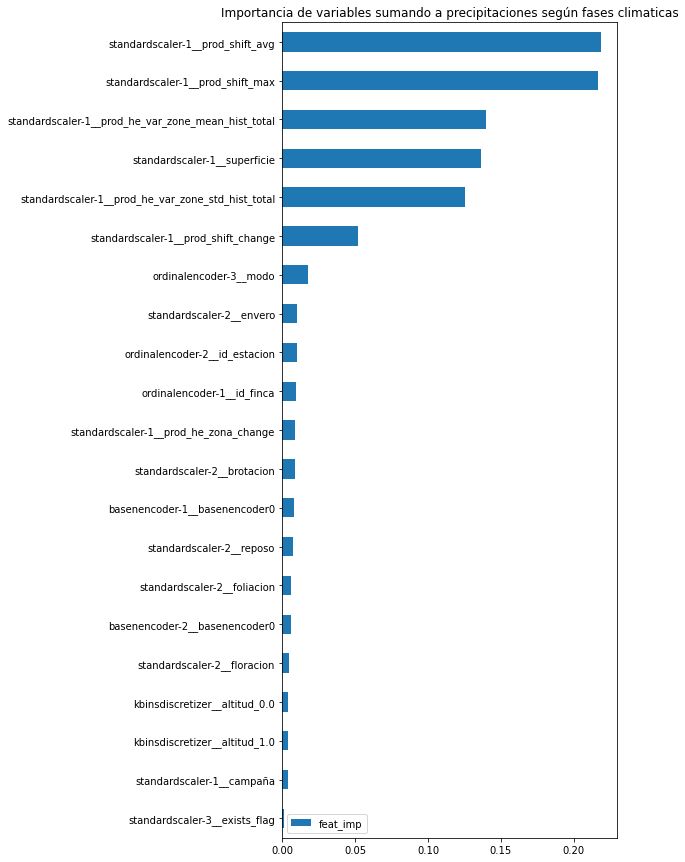

In [113]:
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

plt.title('Importancia de variables sumando a precipitaciones según fases climaticas')
plt.show()


### Comparar vs original

In [24]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [25]:
data_final_eto = data_eto[data_eto.campaña==22]

In [26]:
x_test_v3 = data_final_eto.drop(columns=['produccion'])

In [27]:
X_eto = data_eto[(data_eto.campaña<22)&(data_eto.campaña>14) ].drop(columns='produccion')
y_eto = data_eto[(data_eto.campaña<22)&(data_eto.campaña>14) ]['produccion']

Ajustamos modelo para 2022

In [28]:
m_nuevo = get_base_model_v3()
m_nuevo.fit(X_eto,y_eto)
preds_nuevas = m_nuevo.predict(x_test_v3)

Sorteamos y ploteamos

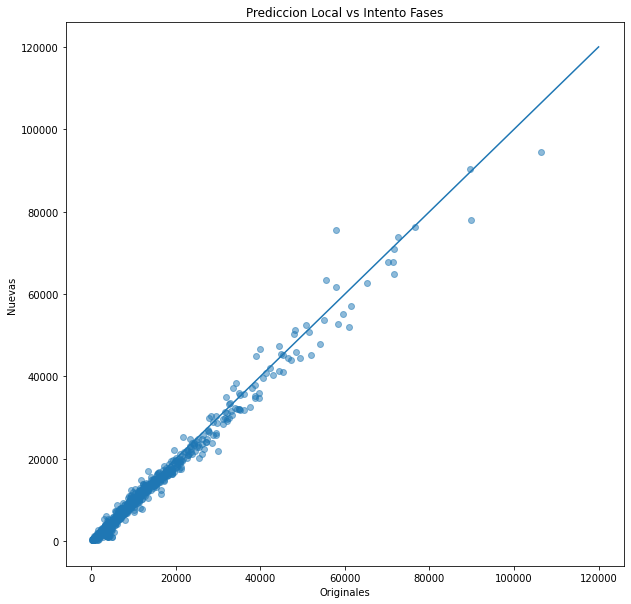

In [30]:
preds_final_v2 = data_final_eto[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Fases')
plt.show()

Guardamos

In [31]:
preds_final_v2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_3.txt', sep="|", header=None, index=False)

## Modelo original sin cambiar mucho 

In [119]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [120]:
n_fincas = X['id_finca'].nunique()
top_fincas = X.id_finca.value_counts()[:int(0.8*n_fincas)].index.values.tolist()
X['id_finca_top'] = X['id_finca'].apply(lambda x: x if x in top_fincas else -1)

n_zonas = X['id_zona'].nunique()
top_zonas = X['id_zona'].value_counts()[:int(0.8*n_zonas)].index.values.tolist()
X['id_zona_top'] = X['id_zona'].apply(lambda x: x if x in top_zonas else -1)

n_var = X['variedad'].nunique()
top_variedad= X['variedad'].value_counts()[:int(0.8*n_var)].index.values.tolist()
X['variedad_top'] = X['variedad'].apply(
    lambda x: x if x in top_variedad else -1)


In [121]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]

In [122]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt
from sklearn.decomposition import PCA

seed = 42

def get_base_model_v2():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),[c for c in percip_cols if 'Sum' in c]),
            
            (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [123]:
from sklearn.model_selection import cross_validate
import numpy as np

m_nuevo = get_base_model_v2()
res = cross_validate(
    estimator=m_nuevo,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4762.75172392 -4546.54217991 -4609.76228565]
test:  [-4828.66303666 -6695.44632565 -5414.76235157]
Train Mean RMSE: -4639.685396494778
Test Mean RMSE: -5646.290571291902


Ajustamos para 2022

In [41]:
x_test_v2 = data_final.drop(columns=['produccion'])

In [43]:
m_nuevo = get_base_model_v2()
m_nuevo.fit(X,y)
preds_nuevas = m_nuevo.predict(x_test_v2)

In [45]:
preds_final_v2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

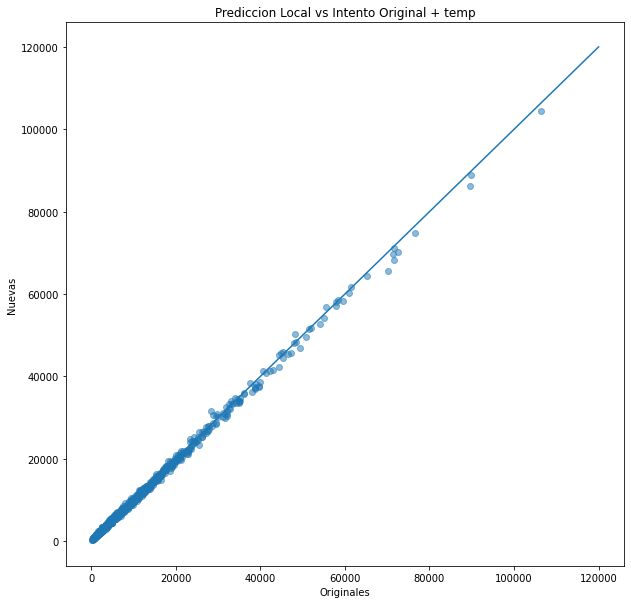

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Original + temp')
plt.show()

In [ ]:
# preds_final_v2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None, index=False)